<a href="https://colab.research.google.com/github/nandwanatarun/EVA-DeepLearning/blob/Session-8%269/S8%269_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Network Correction:

In this part of the assignment - we have to run the given network to 50 epochs to acheive a base accuracy score.

Then, we need to fix the basic architecture to improve on this base accuracy - without really using special convolution techniques

###Importing Modules:

We utilize the code snippen below to import modules to our runtime so that we can use the interfaces exposed by these modules to write and adjust our CNN. We describe only a few modules below that we have not covered in previous assignments:

- **ModelCheckpoint** : This is among the many callbacks provided by Keras that we can use while training our model. We will use this to store the best model weights so that we do not loose out on them by updations performed during subsequent epochs ([Documentation](https://keras.io/callbacks/))

- **ImageDataGenerator** : This module helps us perform image augmentation which is a very strong regularization measure. We can use this to apply transformations like rotation, translation, random crop etc. on out training dataset before passing them on to the network ([Documentation](https://keras.io/preprocessing/image/))

- **Dropout** : This a keras layer that implements dropouts. Dropouts are another regurarization mechanism that drop certain pixel values while training the model so that our model does not overfit to the training images ([Documentation](https://keras.io/layers/core/))

In [1]:
from keras import backend as K
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


### Loading and Pre-Processing the Data:

Some details about the dataset:

- Name : Cifar10
- Number of classes : 10
- Training set size : 50K
- Test set size : 10K
- Image resolution : 32x32

In the code below, we :

- Load the data extracted from a tar.gz file into python variables *(train_features, test_features , test_labels and train_labels)*
- Each of the images are in shape *[3, 32, 32]* and labels are simple integers


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


###Looking at a few examples :

In the code below, we :

- Decode the int labels into class names using a python list

Then for each of our classes we do the following:
- Add a subplot to the figure
- Find the first image in the trainset with that label 
- Plot that image to the subplot
- Set the class name as the title of the subplot



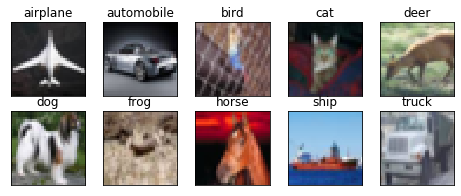

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Plotting model history:

In the code below, we define a utility function that takes the history returned by the *fit_generator()* function and plots the record of the accuracies and losses:

- Plot the train and test accuracies recorded after every epoch
- Plot the train and test losses recorded after every epoch


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

###Getting the accuracy:

The code below defines a utility function that calculates the accuracy given:

- Training Images of shape *(batch_size, height, width, num_channels)*
- Training labels of shape *(batch_size, num_classes)*
- Returns accuracy in percentage


In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

###Processing the data:

We do the following in the code below:

- Convert image matrices to float
- Encode the labels in a One hot format

In [6]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

print(train_features.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000, 10)


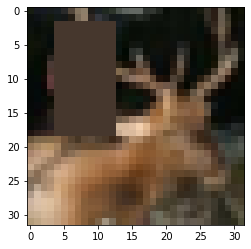

In [7]:
def get_cutout_fn(min_area_ratio, max_area_ratio):
  area_ratio = np.random.uniform(min_area_ratio, max_area_ratio)
  def cutout(X):
    
    H, W, C = X.shape
    
    img_area = H*W
    cutout_area = img_area * area_ratio
    
    
    max_aspect_ratio = max([(H*H)/cutout_area,cutout_area/(W*W)])
    min_aspect_ratio = min([(H*H)/cutout_area,cutout_area/(W*W)])
    
    aspect_ratio = np.random.uniform(min_aspect_ratio, max_aspect_ratio)
    
    cutout_width = int(np.ceil(np.sqrt(cutout_area/aspect_ratio)))
    cutout_height = int(np.ceil(np.sqrt(cutout_area*aspect_ratio)))
    
    if cutout_height == 32:
      top = 0
    else:
      top = np.random.randint(0, H - cutout_height)  
    
    if cutout_width == 32:
      left = 0
    else:
      left = np.random.randint(0, W - cutout_width)
    
    for c in range(C):
      mu = np.mean(X[top:top + cutout_height, left:left + cutout_width, c])
      X[top:top + cutout_height, left: left + cutout_width, c] = mu
      
      
    return X
    
    
  return cutout

cutout_fn = get_cutout_fn(0.1, 0.3)
plt.imshow(cutout_fn(train_features[3465]))

In [0]:
def gradCAM(img, model, layer_name):
  class_idx = np.argmax(model.predict(img)[0])
  
  class_output = model.output[:, class_idx]
  layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, layer.output)[0]
  pooled_grads = K.mean(grads, axis = (0, 1, 2))
  
  iterate = K.function([model.input],[pooled_grads, layer.output[0]])
  
  pooled_grads_val, layer_output_val = iterate([img])
  
  
  for i in range(pooled_grads_val.shape[0]):
    layer_output_val[:,:,i] *= pooled_grads_val[i]
  
  heatmap = np.sum(layer_output_val, axis = 2)
  heatmap = np.maximum(heatmap, 0)
  
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(heatmap * 255)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    
  return heatmap
  
  
  
#plt.imshow(gradCAM(train_features[67].reshape([-1,32,32,3]), model_co, 'conv2d_11'))

###Repairing the model:

We add the following to the model above to better it's performance:

- Dropouts after each conv layer
- Bottleneck layers
- Global average pooling before softmax
- Batch Normalization after each convolution layer

The model thus obtained :

- Contains 824K parameters
- Trains to around 90 % validation accuracy

In [12]:
from keras.regularizers import l2

def get_model():

  # Define the model
  model = Sequential()

  model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3))) #3
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Convolution2D(48, 3, 3, border_mode = 'same')) #5
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Convolution2D(64, 3, 3, border_mode = 'same')) #7
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))


  model.add(MaxPooling2D(pool_size=(2, 2))) #8 -- 16
  model.add(Convolution2D(32,1,1)) #8 -- 16

  model.add(Convolution2D(64, 3, 3, border_mode='same')) #12
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Convolution2D(128, 3, 3, border_mode='same')) #16 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Convolution2D(256, 3, 3, border_mode='same')) #20
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(MaxPooling2D(pool_size=(2, 2))) #21 -- 8
  model.add(Convolution2D(64,1,1)) #21 -- 8

  model.add(Convolution2D(128, 3, 3, border_mode='same')) #29
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Convolution2D(256, 3, 3, border_mode='same')) #37
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Convolution2D(10,1,1))
  model.add(GlobalAveragePooling2D()) #1

  #model.add(Flatten())
  model.add(Activation('softmax'))
  return model;

# Compile the model
model_co = get_model()
model_co.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_co.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 48)        13872     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 48)     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


###Training our better model:

We use the following steps to train our better model:

- We **normalize** the train and test images before passing them through the network
- We **save the best** model obtained after each epoch
- The model took almost 5 times longer to train but the validation accuracy improved from around 82% to around 90%

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`




Epoch 1/100
390/390 [==============================] - 35s 91ms/step - loss: 1.6200 - acc: 0.4067 - val_loss: 2.4116 - val_acc: 0.3303

Epoch 00001: val_acc improved from -inf to 0.33030, saving model to best_model_co.hdf5
Epoch 2/100
390/390 [==============================] - 30s 78ms/step - loss: 1.3006 - acc: 0.5311 - val_loss: 1.5250 - val_acc: 0.5273

Epoch 00002: val_acc improved from 0.33030 to 0.52730, saving model to best_model_co.hdf5
Epoch 3/100
390/390 [==============================] - 31s 78ms/step - loss: 1.1557 - acc: 0.5835 - val_loss: 1.1835 - val_acc: 0.6121

Epoch 00003: val_acc improved from 0.52730 to 0.61210, saving model to best_model_co.hdf5
Epoch 4/100
390/390 [==============================] - 30s 78ms/step - loss: 1.0615 - acc: 0.6229 - val_loss: 1.1395 - val_acc: 0.6286

Epoch 00004: val_acc improved from 0.61210 to 0.62860, saving model to best_model_co.hdf5
Epoch 5/100
390/390 [==============================] - 30s 78ms/step - loss: 1.0029 - acc: 0.6462

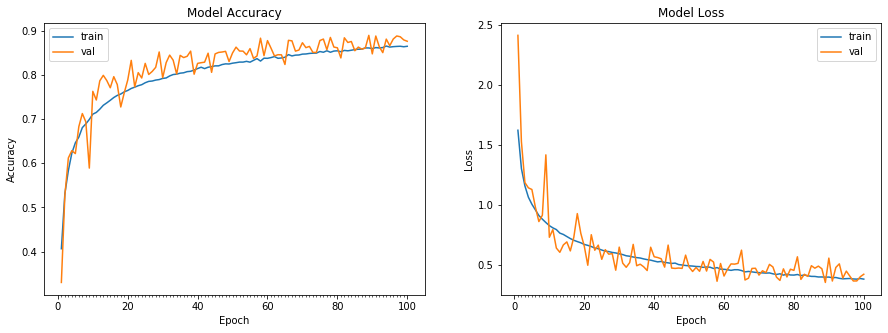

Accuracy on test data is: 88.95


In [13]:

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   preprocessing_function = get_cutout_fn(0.1, 0.3))
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

CKPT = ModelCheckpoint(filepath = 'best_model_co.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)


# train the model
start = time.time()
# Train the model
model_info = model_co.fit_generator(train_data_iter,
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

# compute test accuracy
model_co.load_weights('./best_model_co.hdf5')
test_features_n, test_labels_n = test_data_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features_n, test_labels_n, model_co))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/u

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 48)        13872     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 48)        192       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 48)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`


Epoch 1/50
390/390 [==============================] - 28s 71ms/step - loss: 1.3367 - acc: 0.5106 - val_loss: 1.1261 - val_acc: 0.6008

Epoch 00001: val_acc improved from -inf to 0.60080, saving model to best_model_wco.hdf5
Epoch 2/50
390/390 [==============================] - 25s 65ms/step - loss: 0.9535 - acc: 0.6595 - val_loss: 1.4216 - val_acc: 0.5602

Epoch 00002: val_acc did not improve from 0.60080
Epoch 3/50
390/390 [==============================] - 25s 64ms/step - loss: 0.7924 - acc: 0.7220 - val_loss: 0.9603 - val_acc: 0.6832

Epoch 00003: val_acc improved from 0.60080 to 0.68320, saving model to best_model_wco.hdf5
Epoch 4/50
390/390 [==============================] - 25s 65ms/step - loss: 0.6967 - acc: 0.7584 - val_loss: 1.0943 - val_acc: 0.6528

Epoch 00004: val_acc did not improve from 0.68320
Epoch 5/50
390/390 [==============================] - 25s 65ms/step - loss: 0.6321 - acc: 0.7795 - val_loss: 0.8314 - val_acc: 0.7203

Epoch 00005: val_acc improved from 0.68320 to 

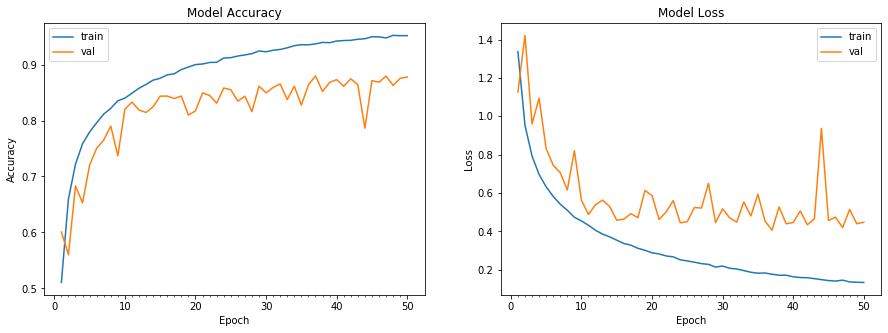

Accuracy on test data is: 87.99


In [14]:
model_wco = get_model()
model_wco.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_wco.summary()

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1
                                   )
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

CKPT = ModelCheckpoint(filepath = 'best_model_wco.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)


# train the model
start = time.time()
# Train the model
model_info = model_wco.fit_generator(train_data_iter,
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

# compute test accuracy
model_wco.load_weights('./best_model_wco.hdf5')
test_features, test_labels = test_data_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model_wco))

In [0]:
(train_features_1, train_labels_1), (test_features_1, test_labels_1) = cifar10.load_data()
test_features_scaled = test_features_1.astype('float32')/255
test_labels_1 = np_utils.to_categorical(test_labels_1, num_classes)
test_datagen.fit(test_features_scaled)
#test_data_iter =  test_datagen.flow(test_features_scaled,test_labels_1, batch_size = 10000)
test_features = test_datagen.standardize(test_features_scaled)


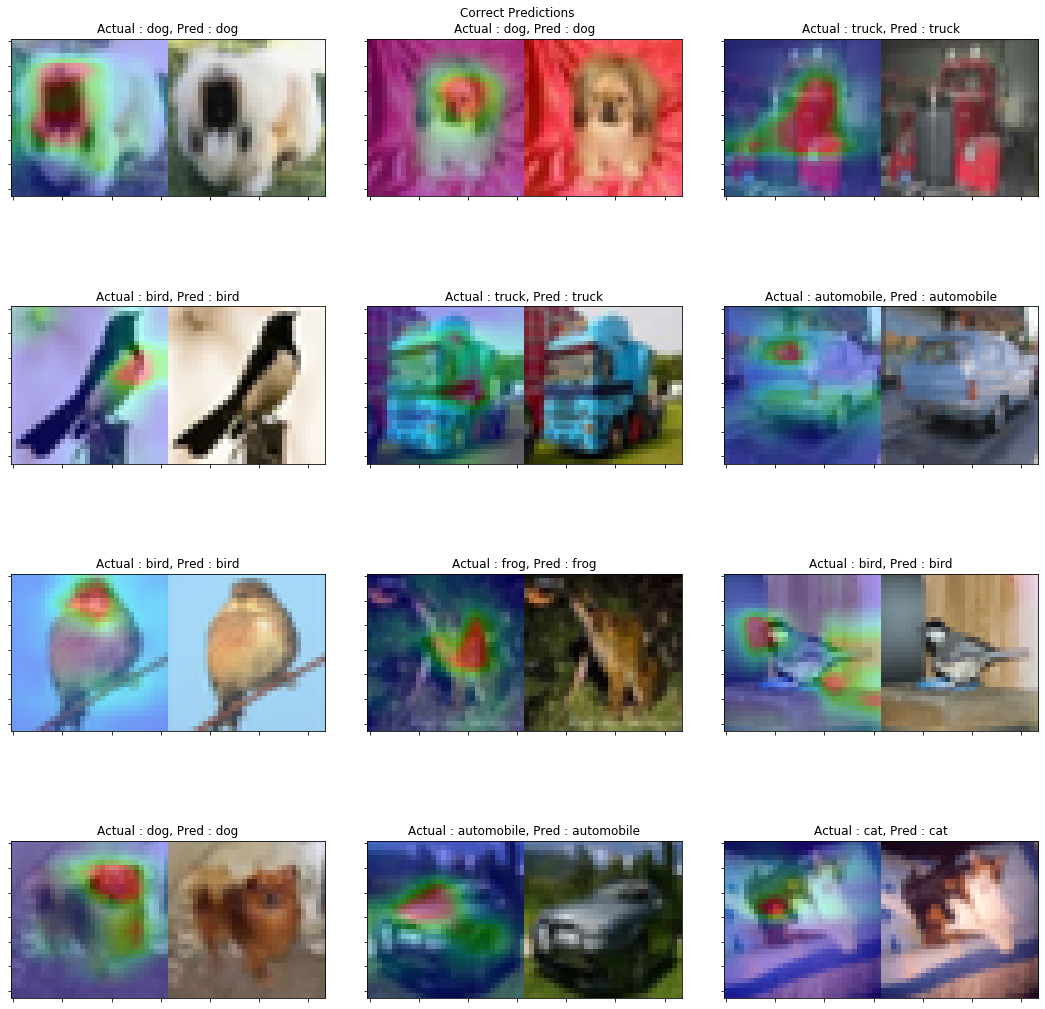

In [16]:


actuals = np.argmax(test_labels_1, axis = 1)
preds = np.argmax(model_co.predict(test_features), axis = 1)

correct_idx = [idx for idx in range(10000) if actuals[idx] == preds[idx]]
incorrect_idx = [idx for idx in range(10000) if idx not in correct_idx]

correct_plot_idx = np.random.choice(correct_idx, size = 12, replace = False)
#incorrect_plot_idx = np.random.choice(incorrect_idx, size = 12, replace = False)

fig, ax = plt.subplots(4,3, figsize = (15,15))
fig.tight_layout()
fig.suptitle("Correct Predictions")

plot_idx = 0

for i in range(4):
  for j in range(3):
    img = test_features[correct_plot_idx[plot_idx]].reshape([-1,32,32,3])
    
    unnormalized_img = test_features_1[correct_plot_idx[plot_idx]]
    
    heatmap = gradCAM(img, model_co, "conv2d_11")
    
    superimposed_img = cv2.addWeighted(unnormalized_img, 0.7, heatmap, 0.3, 0, dtype = cv2.CV_32F)/255
    
    true_class = class_names[actuals[correct_plot_idx[plot_idx]]]
    pred_class = class_names[preds[correct_plot_idx[plot_idx]]]
    plot_idx += 1
    plot_img = np.concatenate((superimposed_img, unnormalized_img/255), axis = 1)
    ax[i, j].imshow(plot_img)
    ax[i, j].set_xticklabels([])
    ax[i, j].set_yticklabels([])
    ax[i, j].set_title("Actual : {}, Pred : {}".format(true_class, pred_class))




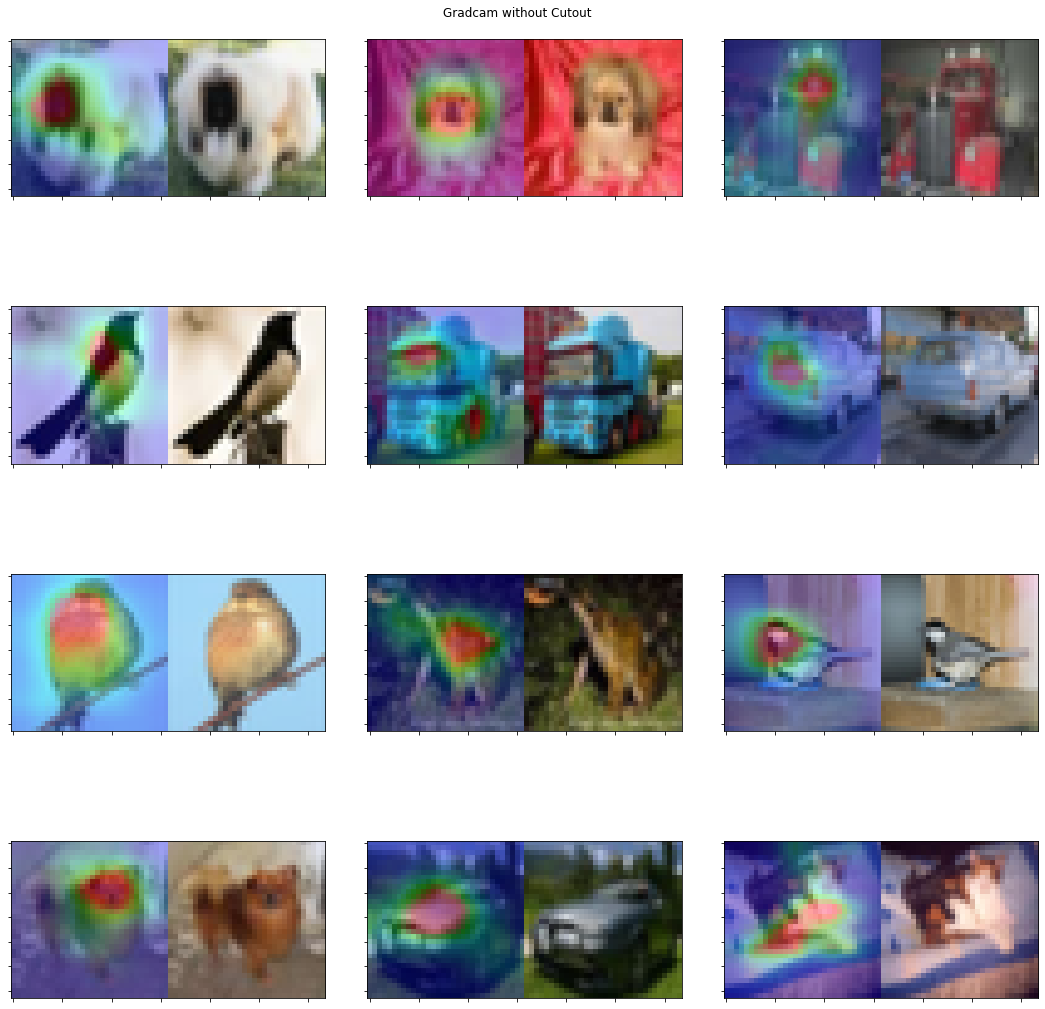

In [17]:
fig, ax = plt.subplots(4,3, figsize = (15,15))
fig.tight_layout()
fig.suptitle("Gradcam without Cutout")

plot_idx = 0

for i in range(4):
  for j in range(3):
    img = test_features[correct_plot_idx[plot_idx]].reshape([-1,32,32,3])
    
    unnormalized_img = test_features_1[correct_plot_idx[plot_idx]]
    
    heatmap = gradCAM(img, model_wco, "conv2d_22")
    superimposed_img = cv2.addWeighted(unnormalized_img, 0.7, heatmap, 0.3, 0, dtype = cv2.CV_32F)/255
    
    true_class = class_names[actuals[correct_plot_idx[plot_idx]]]
    pred_class = class_names[preds[correct_plot_idx[plot_idx]]]
    plot_idx += 1
    plot_img = np.concatenate((superimposed_img, unnormalized_img/255), axis = 1)
    ax[i, j].imshow(plot_img)
    ax[i, j].set_xticklabels([])
    ax[i, j].set_yticklabels([])
    #ax[i, j].set_title("Actual : {}, Pred : {}".format(true_class, pred_class))
    
    
plt.show()